In [7]:
import yfinance as yf
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# For time stamps
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from keras.callbacks import EarlyStopping
from keras.constraints import MaxNorm
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool

#iShares MSCI World Index ETF
data = yf.download('AAPL', start='2012-01-01', end=datetime.now())
#data = yf.download('AAPL', period='4y')
df = pd.DataFrame(data)

[*********************100%%**********************]  1 of 1 completed


In [8]:
df = df['Adj Close']
df_shifted = df.shift().dropna().values
df = df.values
trend_values = [j - i for i, j in zip(df[1:], df_shifted)]

In [9]:
#scaler = MinMaxScaler(feature_range=(-1, 1))
trend_values = [(float(value),) for value in trend_values]
#values = np.asarray(values)
#trend_values = scaler.fit_transform(trend_values)

In [4]:
print(trend_values)

[(-0.06690406799316406,), (-0.1389617919921875,), (-0.13229846954345703,), (0.020284652709960938,), (-0.04571342468261719,), (0.020887374877929688,), (0.03512096405029297,), (0.04783153533935547,), (-0.148040771484375,), (-0.13350963592529297,), (0.04117107391357422,), (0.22554779052734375,), (-0.21525192260742188,), (0.21192169189453125,), (-0.7947044372558594,), (0.06146049499511719,), (-0.08022880554199219,), (-0.17347335815429688,), (-0.10504817962646484,), (0.008775711059570312,), (0.03239631652832031,), (-0.13805103302001953,), (-0.12987422943115234,), (-0.14713764190673828,), (-0.23764705657958984,), (-0.4992237091064453,), (-0.007568359375,), (-0.2779226303100586,), (-0.20768356323242188,), (0.35693931579589844,), (-0.13744449615478516,), (0.0027256011962890625,), (-0.38539886474609375,), (0.05479717254638672,), (-0.10141658782958984,), (-0.18225479125976562,), (-0.10141658782958984,), (-0.2921466827392578,), (-0.21282005310058594,), (-0.06146430969238281,), (-0.021492004394531

In [10]:
#df = df['Adj Close']
# Normalize between 0 and 1 with min-max scaler
#scaler = MinMaxScaler()
#values = df.values
#values = [(float(value),) for value in values]
#values = np.asarray(values)
#values = scaler.fit_transform(values)
training_data_len = math.ceil(len(trend_values)* 0.8)

In [11]:
# Perhaps use train_test_split from sklearn
train_set = trend_values[:training_data_len]
val_set = trend_values[training_data_len:]
#train_test_split(trend_values, test_size=0.2)



GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 62, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 62, 4)             96        
                                                                 
 dropout_2 (Dropout)         (None, 62, 4)             0         
                                                                 
 lstm_3 (LSTM)               (None, 8)                 416       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                

/Users/arnewiese/miniconda3/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyError: 'val_loss'

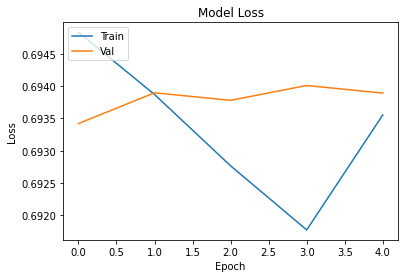

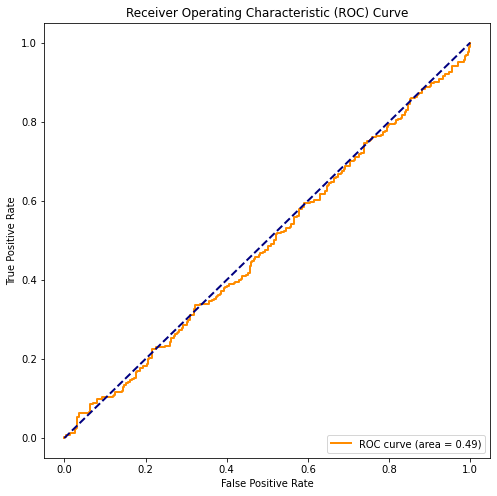

In [12]:
import os
import random
import numpy as np
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
import matplotlib

GPU_STRING = '/gpu:0'
BATCH_SIZE = 64
MODEL_NAME = "MLP"
EPOCHS = 5
STEPS_PER_EPOCH = 10
VALIDATION_STEPS = 32
SEQ_LEN_PAST = 62 
SEQ_LEN_FUTURE = 1
NUM_INPUT_PARAMETERS = 1
NUM_OUTPUT_PARAMETERS = 1

class ModelHistory(tf.keras.callbacks.Callback):
  def __init__(self, model_path):
    self.model_path = model_path
    self.loss = []
    self.loss_val = []
    self.mae = []
    self.mae_val = []
    self.mse = []
    self.mse_val = []
    self.accuracy = []
    self.accuracy_val = []

  def on_epoch_end(self, batch, logs):
    self.loss.append(logs.get('loss'))
    self.loss_val.append(logs.get('val_loss'))
    self.mae.append(logs.get('mean_absolute_error'))
    self.mse.append(logs.get('mean_squared_error'))
    self.mae_val.append(logs.get('val_mean_absolute_error'))
    self.mse_val.append(logs.get('val_mean_squared_error'))
    self.accuracy.append(logs.get('accuracy'))
    self.accuracy_val.append(logs.get('val_accuracy'))
    self.plot_data()


  def plot_data(self):
    vis_path = os.path.join(self.model_path, 'vis')

    if not os.path.exists(vis_path):
      os.makedirs(vis_path)

    model_name = self.model_path.split('/')[-1]

    plt.clf()
    plt.plot(self.loss)
    plt.plot(self.loss_val)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig(os.path.join(vis_path, 'loss.png'))

def setup_model_mlp():
  input = tf.keras.layers.Input(shape=(SEQ_LEN_PAST, NUM_INPUT_PARAMETERS), name='input')

  dp = 0.4
  x = tf.keras.layers.Flatten()(input)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(dp)(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(dp)(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(dp)(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dropout(dp)(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dropout(dp)(x)  
  x = tf.keras.layers.Dense(SEQ_LEN_FUTURE * NUM_OUTPUT_PARAMETERS, activation='sigmoid')(x)
  #x = tf.keras.layers.Reshape((SEQ_LEN_FUTURE, NUM_OUTPUT_PARAMETERS))(x)

  model = tf.keras.models.Model(input, x)
  return model

def setup_model_conv_1d():
  input = tf.keras.layers.Input(shape=(SEQ_LEN_PAST, NUM_INPUT_PARAMETERS), name='input')

  dp = 0.4
  x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(input)
  x = tf.keras.layers.Dropout(dp)(x)
  x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
  x = tf.keras.layers.Dropout(dp)(x)
  x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
  x = tf.keras.layers.Dropout(dp)(x)  
  x = tf.keras.layers.GlobalAveragePooling1D()(x)

  x = tf.keras.layers.Dense(128, activation='relu')(x)  
  x = tf.keras.layers.Dense(SEQ_LEN_FUTURE * NUM_OUTPUT_PARAMETERS, activation='sigmoid')(x)
  #x = tf.keras.layers.Reshape((SEQ_LEN_FUTURE, NUM_OUTPUT_PARAMETERS))(x)

  model = tf.keras.models.Model(input, x)
  return model  

def setup_model_lstm():
  input = tf.keras.layers.Input(shape=(SEQ_LEN_PAST, NUM_INPUT_PARAMETERS), name='input')

  dropout_rate = 0.5
  x = tf.keras.layers.LSTM(4, return_sequences=True)(input)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = tf.keras.layers.LSTM(8)(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = tf.keras.layers.Dense(SEQ_LEN_FUTURE * NUM_OUTPUT_PARAMETERS, activation='sigmoid')(x)
  #x = tf.keras.layers.Reshape((SEQ_LEN_FUTURE, NUM_OUTPUT_PARAMETERS))(x)

  model = tf.keras.models.Model(input, x)
  return model

def transformer_encoder(inputs, dropout=0.25, head_size=256, num_heads=32, ff_dim=4):

    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)

    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def setup_model_transformer(dropout=0.4, num_transformer_blocks=8, mlp_units=[128]):
  inputs = tf.keras.Input(shape=(SEQ_LEN_PAST, NUM_INPUT_PARAMETERS))
  x = inputs

  for _ in range(num_transformer_blocks):
      x = transformer_encoder(x)

  x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
      x = tf.keras.layers.Dense(dim, activation="relu")(x)
      x = tf.keras.layers.Dropout(dropout)(x)

  outputs = tf.keras.layers.Dense(SEQ_LEN_FUTURE * NUM_OUTPUT_PARAMETERS)(x)
  outputs = tf.keras.layers.Reshape((SEQ_LEN_FUTURE, NUM_OUTPUT_PARAMETERS))(outputs)

  return tf.keras.Model(inputs, outputs)

def select_data(batch_size, values):
  selected_inputs = []
  selected_labels = []

  num = 0
  while num < batch_size:
    idx_seq = random.randint(SEQ_LEN_PAST, len(values) - 1)
    sub_seq_input = values[idx_seq-SEQ_LEN_PAST:idx_seq]
    trend_val = values[idx_seq:idx_seq+1][0]
    if (trend_val[0] >= 0): 
      sub_seq_label = 1
    else:
      sub_seq_label = 0

    selected_inputs.append(sub_seq_input)
    selected_labels.append(sub_seq_label)

    num += 1

  return np.asarray(selected_inputs), np.asarray(selected_labels)

def data_generator(values, batch_size):
  while True:
   inputs, labels = select_data(batch_size, values)

   #Data Augmentation
   #mu = 0
   #sigma = 0.1
   #rnd = np.random.normal(mu, sigma, size=inputs.shape)
   #inputs += rnd
  
   yield inputs, labels

def plot_data_partial(samples, sub_seq_input, sub_seq_label, sub_seq_pred, model_path, epoch, count):
    vis_path = os.path.join(model_path, 'vis', 'plots')
    if not os.path.exists(vis_path):
      os.makedirs(vis_path)

    input_samples_y = []
    for i in range(sub_seq_input.shape[1]):
      input_samples_y.append(sub_seq_input[0][i][0])

    label_samples_y = []
    for i in range(sub_seq_label.shape[0]):
      label_samples_y.append(sub_seq_label[i][0])

    pred_samples_y = []
    for i in range(sub_seq_pred.shape[0]):
      pred_samples_y.append(sub_seq_pred[i][0])

    plt.clf()

    tmp = list(range(0, len(input_samples_y)))
    plt.scatter(tmp, input_samples_y)
    plt.scatter(len(input_samples_y), pred_samples_y)
    plt.scatter(len(input_samples_y), label_samples_y)

    plt.title('Sin Plot Partial')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(['Inputs', 'Pred', 'Label'], loc='upper left')
    plt.savefig(vis_path + '/' + str(epoch).zfill(4) + '_' + str(count).zfill(4) + '_p.png')

def plot_unroll(samples, model_path, model, epoch, count):
  vis_path = os.path.join(model_path, 'vis', 'plots')
  if not os.path.exists(vis_path):
    os.makedirs(vis_path)

  num_steps = 100

  index = random.randint(0, len(samples) - num_steps - SEQ_LEN_PAST)
  rolling_buffer = samples[index:SEQ_LEN_PAST + index]
  initial_samples = rolling_buffer.copy()


  pred_samples = []
  for i in range(num_steps):
    input_seq = np.expand_dims(np.asarray(rolling_buffer), axis=0)

    preds = model.predict(input_seq)[0]
    preds = preds.astype(np.float32)

    pred_samples.append((preds[0][0],))
    rolling_buffer.append((preds[0][0],))

    rolling_buffer = rolling_buffer[1:]


  y_pred = []
  for i in range(len(pred_samples)):
    y_pred.append(pred_samples[i][0])

  y_initial = []
  for i in range(len(initial_samples)):
    y_initial.append(initial_samples[i][0])

  y_samples = []
  for i in range(len(samples)):
    y_samples.append(samples[i][0])

  plt.clf()
  tmp1 = list(range(0, len(y_samples)))
  tmp2 = list(range(index, index + len(y_initial)))
  tmp3 = list(range(index + len(y_initial), index + len(y_pred)+len(y_initial)))


  plt.scatter(tmp1, y_samples)
  plt.scatter(tmp2, y_initial)
  plt.scatter(tmp3, y_pred)
  plt.title('Rolling Predictions')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.legend(['GT', 'Initial', 'Pred'], loc='upper left')
  plt.savefig(vis_path + '/' + str(epoch).zfill(4) + '_' + str(count).zfill(4) + '_u.png')

def plot_sigmoid(values, model, vis_path):
  inputs = np.asarray(values[len(values) - len(val_set) - SEQ_LEN_PAST:])
  X_test = []
  Y_test = []
  for i in range(SEQ_LEN_PAST, inputs.shape[0]):
    X_test.append(inputs[i - SEQ_LEN_PAST:i, 0])
    Y_test.append(1 if inputs[i, 0] >= 0 else 0)

  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 

  # Predict probabilities on the validation data
  val_pred_probs = model.predict(X_test)

  # Convert probabilities to binary predictions (0 or 1)
  val_predictions = (val_pred_probs > 0.5).astype(int)

  # True labels for the validation set
  val_true_labels = Y_test

  # Evaluate accuracy
  accuracy = accuracy_score(val_true_labels, val_predictions)
  print(f'Accuracy: {accuracy:.4f}')

  # Evaluate precision, recall, and F1-score
  precision = precision_score(val_true_labels, val_predictions)
  recall = recall_score(val_true_labels, val_predictions)
  f1 = f1_score(val_true_labels, val_predictions)

  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1-Score: {f1:.4f}')

  # Evaluate AUC-ROC
  roc_auc = roc_auc_score(val_true_labels, val_pred_probs)
  print(f'AUC-ROC: {roc_auc:.4f}')

  # Plot ROC curve
  fpr, tpr, _ = roc_curve(val_true_labels, val_pred_probs)
  plt.figure(figsize=(8, 8))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  #plt.show()
  plt.savefig(vis_path + '/' + 'ROC.png')

def plot_compare(values, model, vis_path):
    inputs = np.asarray(values[len(values) - len(val_set) - SEQ_LEN_PAST:])
    X_test = []
    for i in range(SEQ_LEN_PAST, inputs.shape[0]):
      X_test.append(inputs[i - SEQ_LEN_PAST:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    pred = model.predict(X_test)
    pred = pred.astype(np.float32)
    pred = np.squeeze(pred)

    pred_dif = [pred[i + 1] - inputs.flatten()[i] for i in range(pred.shape[0] - 1)] 
    val_dif = [inputs.flatten()[i + 1] - inputs.flatten()[i] for i in range(pred.shape[0] - 1)] 
  
    # Compute precision array
    precision = [1 if (p_diff * v_diff > 0) else 0 for p_diff, v_diff in zip(pred_dif, val_dif)]

    pred = np.asarray(scaler.inverse_transform([(float(value),) for value in pred]))
    val = np.asarray(scaler.inverse_transform([(float(value),) for value in inputs]))
  
    plt.clf()
    # Plotting the predictions (blue)
    plt.plot(range(len(train_set), len(values)), pred, color='C0', label='Predictions')
    # Plotting the actual values (lightgray)
    plt.plot(range(len(train_set), len(values) + SEQ_LEN_PAST), val, color='lightgray', label='Actual Value')
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tick_params(axis='both', which='both', length=0)

    min_val = range(len(train_set), len(values))[0]
    max_val = range(len(train_set), len(values))[-1] 

    # Set x-axis ticks to min and max values
    plt.xticks([min_val, max_val])

    # Set y-axis ticks to min and max values
    plt.yticks([min(val.min(), pred.min()), max(val.max(), pred.max())])

    # Set x-axis label
    plt.xlabel('Time-Steps')

    # Set y-axis label
    plt.ylabel('Adj. Close')

    # Set title
    plt.title('AAPL Prediction')

    # Directly label the blue plot
    #plt.text(max_val + 5, val[-1], 'Actual Value', color='orange', ha='left', va='center')

    # Directly label the blue plot
    plt.text(max_val + 5, pred[-1], f'Predictions with\nprecision {round(precision.count(1) / len(pred_dif) * 100 ,2)}%', color='C0', ha='left', va='center')
    # Save the plot
    plt.savefig(vis_path + '/' + 'comparison.png')

def val_func(val_set, model_path, model, epoch):

  num_plots = 1

  for i in range(num_plots):
    idx_seq = random.randint(SEQ_LEN_PAST, len(val_set) - SEQ_LEN_FUTURE)
    sub_seq_input = val_set[idx_seq-SEQ_LEN_PAST:idx_seq]
    sub_seq_label = val_set[idx_seq:idx_seq+SEQ_LEN_FUTURE]

    sub_seq_input = np.asarray(sub_seq_input)
    sub_seq_label = np.asarray(sub_seq_label)

    sub_seq_input = np.expand_dims(sub_seq_input, axis=0)

    preds = model.predict(sub_seq_input)[0]
    preds = preds.astype(np.float32)

    plot_data_partial(val_set, sub_seq_input, sub_seq_label, preds, model_path, epoch, i)
    #plot_unroll(val_set, model_path, model, epoch, i)

def train(data_path, model_path, model, from_checkpoint=False):

  train_gen = data_generator(train_set, BATCH_SIZE)
  val_gen = data_generator(val_set, BATCH_SIZE)

  opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)

  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
  model.summary()

  # Set up early stopping
  early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)

  model_history_callback = ModelHistory(model_path)
  #checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(model_path + 'model-{epoch:03d}.h5', verbose=1, monitor='val_mae', save_best_only=True, mode='auto')
  #val_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: val_func(val_set, model_path, model, epoch))
  #comparison_callback = tf.keras.callbacks.LambdaCallback(on_train_end=lambda _: plot_compare(values, model, model_path))
  sigmoid_callback = tf.keras.callbacks.LambdaCallback(on_train_end=lambda _: plot_sigmoid(trend_values, model, model_path)) 
  history = model.fit(train_gen, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, epochs=EPOCHS,
                       validation_data=val_gen, callbacks=[model_history_callback, sigmoid_callback, early_stopping],
                       shuffle=True, verbose=1)
  
  # Find the epoch number with the best validation accuracy and best validation loss
  #best_val_acc_epoch = np.argmax(history.history['val_accuracy'])  # Use 'val_acc' if 'val_accuracy' doesn't work
  best_val_loss_epoch = np.argmin(history.history['val_loss'])

  # Retrieve metrics at the best validation accuracy epoch
  #best_val_acc = history.history['val_acc'][best_val_acc_epoch]
  #best_train_acc_at_best_val_acc = history.history['accuracy'][best_val_acc_epoch]
  #best_train_loss_at_best_val_acc = history.history['loss'][best_val_acc_epoch]
  #best_val_loss_at_best_val_acc = history.history['val_loss'][best_val_acc_epoch]

  # Retrieve metrics at the best validation loss epoch
  best_val_loss = history.history['val_loss'][best_val_loss_epoch]
  best_train_acc_at_best_val_loss = history.history['accuracy'][best_val_loss_epoch]
  best_train_loss_at_best_val_loss = history.history['loss'][best_val_loss_epoch]
  best_val_acc_at_best_val_loss = history.history['val_acc'][best_val_loss_epoch]

  # Print metrics at the best validation accuracy epoch
  #print(f"Epoch with Best Validation Accuracy ({best_val_acc_epoch+1}):")
  #print(f"- Best Validation Accuracy: {best_val_acc}")
  #print(f"- Training Accuracy: {best_train_acc_at_best_val_acc}")
  #print(f"- Training Loss: {best_train_loss_at_best_val_acc}")
  #print(f"- Validation Loss: {best_val_loss_at_best_val_acc}")

  # Print metrics at the best validation loss epoch
  print(f"\nEpoch with Best Validation Loss ({best_val_loss_epoch+1}):")
  print(f"- Best Validation Loss: {best_val_loss}")
  print(f"- Training Accuracy: {best_train_acc_at_best_val_loss}")
  print(f"- Training Loss: {best_train_loss_at_best_val_loss}")
  print(f"- Validation Accuracy: {best_val_acc_at_best_val_loss}")

  
def run():
  physical_devices = tf.config.list_physical_devices('GPU')
  print("\n")
  print("GPUs:", physical_devices)
  print("\n")

  with tf.device(GPU_STRING):
    path = 'zeitreihen/'
    data_path = path + 'datasets/sin_data/'
    model_path = path + 'models/' + MODEL_NAME + '/'

    if not os.path.exists(model_path):
      os.makedirs(model_path)

    global model
    #model = setup_model_mlp()
    #model = setup_model_conv_1d()
    model = setup_model_lstm()
    #model = setup_model_transformer()

    mode = 'train'

    train(data_path, model_path, model)

if __name__== "__main__":
  run()

In [59]:
inputs = np.asarray(trend_values[len(trend_values) - len(val_set) - SEQ_LEN_PAST:])
X_test = []
Y_test = []
for i in range(SEQ_LEN_PAST, inputs.shape[0]):
    X_test.append(inputs[i - SEQ_LEN_PAST:i, 0])
    Y_test.append(1 if inputs[i, 0] >= 0 else 0)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 

# Predict probabilities on the validation data
val_pred_probs = model.predict(X_test)
val_pred_probs = [1 if i >= 0.5 else 0 for i in val_pred_probs]
inputs = [1 if i >= 0 else 0 for i in inputs[SEQ_LEN_PAST:]]

print(list(zip(val_pred_probs, inputs)).count((0, 1)))

19/19 [==============================] - 0s 8ms/step
114


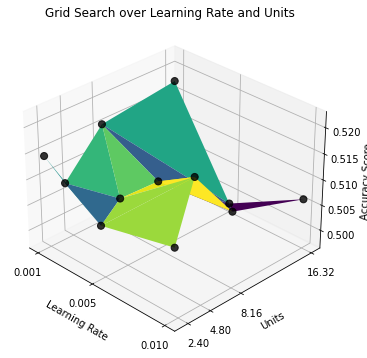

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D

# Data
learning_rate_units_data = [
    (0.510262, 0.013578, {'learning_rate': 0.01, 'units': [2, 4]}),
    (0.521348, 0.021125, {'learning_rate': 0.01, 'units': [4, 8]}),
    (0.511266, 0.014090, {'learning_rate': 0.01, 'units': [8, 16]}),
    (0.506215, 0.011511, {'learning_rate': 0.01, 'units': [16, 32]}),
    (0.506888, 0.015106, {'learning_rate': 0.005, 'units': [2, 4]}),
    (0.510261, 0.013917, {'learning_rate': 0.005, 'units': [4, 8]}),
    (0.509924, 0.008439, {'learning_rate': 0.005, 'units': [8, 16]}),
    (0.498152, 0.004796, {'learning_rate': 0.005, 'units': [16, 32]}),
    (0.514629, 0.008147, {'learning_rate': 0.001, 'units': [2, 4]}),
    (0.507574, 0.018122, {'learning_rate': 0.001, 'units': [4, 8]}),
    (0.515643, 0.016376, {'learning_rate': 0.001, 'units': [8, 16]}),
    (0.517644, 0.020587, {'learning_rate': 0.001, 'units': [16, 32]})
]

# Extracting values
accuracy_scores_lr_units = [item[0] for item in learning_rate_units_data]
std_deviation_lr_units = [item[1] for item in learning_rate_units_data]
params_lr_units = [item[2] for item in learning_rate_units_data]

# Flatten the arrays for a 1D representation
learning_rates_flat = [param['learning_rate'] for param in params_lr_units]
units_flat = [param['units'] for param in params_lr_units]
units_flat = [unit[0] + unit[1] / 100 for unit in units_flat]  # Combine units into a single value

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

triang_lr_units = mtri.Triangulation(learning_rates_flat, units_flat)

ax.plot_trisurf(triang_lr_units, accuracy_scores_lr_units, cmap='viridis')
ax.scatter(learning_rates_flat, units_flat, accuracy_scores_lr_units, marker='o', s=50, c="black", alpha=0.8)
ax.view_init(elev=30, azim=-45)

ax.set_title('Grid Search over Learning Rate and Units')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Units')
ax.set_zlabel('Accuracy Score')

ax.set_xticks(np.unique(learning_rates_flat))
ax.set_yticks(np.unique([2.4, 4.8, 8.16, 16.32]))

plt.show()


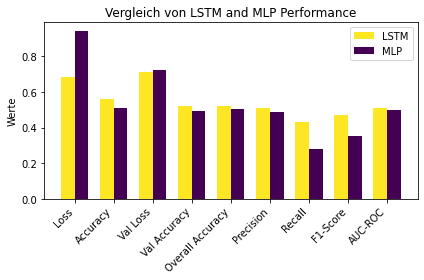

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for both models
metrics = ['Loss', 'Accuracy', 'Val Loss', 'Val Accuracy', 'Overall Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
model1_values = [0.6830, 0.5597, 0.7113, 0.5190, 0.5230, 0.5100, 0.4339, 0.4689, 0.5108]
model2_values = [0.9437, 0.5088, 0.7241, 0.4927, 0.5066, 0.4852, 0.2780, 0.3534, 0.5014]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, model1_values, width, label='LSTM', color='#fde725')
rects2 = ax.bar(x + width/2, model2_values, width, label='MLP', color='#440154')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Werte')
ax.set_title('Vergleich von LSTM and MLP Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha="right")
ax.legend()

fig.tight_layout()

plt.show()
